# Colab Setup

In [0]:
!nvidia-smi

Fri Sep 27 16:00:18 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!pip install gdown --quiet

In [0]:
!pip install scikit-plot --quiet

# Imports and Data Setup

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import numpy as np  
import pandas as pd
from pathlib import Path
import scipy.io
import h5py

import sklearn.metrics as metrics
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.initializers import he_normal
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from scipy.signal import resample

from scipy.signal import find_peaks as findPeaks
from scipy import sparse
from scipy.sparse.linalg import spsolve

from pathlib import Path
import gdown

import scikitplot as skplt

In [0]:
datapath = Path('./data')

In [0]:
# Download Raw Data
inertial_url = 'https://drive.google.com/uc?export=download&id=1gGd3nq889m9iU8gkyqk1YHLOqmR31VWb'
inertial_file = 'Inertial.zip'

skeleton_url = 'https://drive.google.com/uc?export=download&id=1rvnhTitWIWF-9biYyzzGXXcaY5BXecV1'
skeleton_file = 'Skeleton.zip'

gdown.download(inertial_url, inertial_file, quiet=True)
gdown.download(skeleton_url, skeleton_file, quiet=True)

'Skeleton.zip'

In [0]:
!unzip -qq ./Inertial.zip -d ./data/

In [0]:
!unzip -qq ./Skeleton.zip -d ./data/

# Process Dataset

## Process Skeleton Data

In [0]:
def import_data(file_type, action, subject, trial):
    filename = datapath/f'{file_type}/a{action}_s{subject}_t{trial}_{file_type.lower()}.mat'
    if Path(filename).is_file():
        mat = scipy.io.loadmat(filename)
        if file_type.lower() == 'inertial':
            return mat['d_iner']
        else:
            return mat['d_skel']
    else:
        return None

In [0]:
def calculate_angle(point1,point2,point3):


    point2_1 = point1 - point2
    point2_3 = point3 - point2

    cosine_angle = np.dot(point2_1, point2_3) / (np.linalg.norm(point2_1) * np.linalg.norm(point2_3))
    angle = np.arccos(cosine_angle)
    angle = np.degrees(angle)

    return angle

In [0]:
# Importing Skeleton Data Variance
def process_skeleton_angles():

    reshaped_data = np.zeros([861,116,60])
    trDat = []
    trLbl = []
    tsDat = []
    tsLbl = []
 
    index = 0
    counter = 0
    subject = 0

    for i in range (864):
        
        if counter == 32:
            counter = 0
        subject = int((counter-counter%4)/4+1)
        counter = counter + 1
        action = int((i-i%32)/32+1)
        take = i%4+1
        
        data = import_data('Skeleton',action,subject,take)
        
        
        if data is not None:
                        
            temp_array = np.zeros([data.shape[2],60])
            temp_array_angle = np.zeros([12,data.shape[2]])
            
            for j in range (data.shape[2]):
                temp_array[j,:] = data[:,:,j].flatten()
                
                temp_array_angle[0,j]= calculate_angle(temp_array[j,0:2],temp_array[j,3:5],temp_array[j,6:8]) #head_spine_angle
                temp_array_angle[1,j]= calculate_angle(temp_array[j,3:5],temp_array[j,6:8],temp_array[j,9:11]) #spine_angle
                
                temp_array_angle[2,j]= calculate_angle(temp_array[j,15:17],temp_array[j,18:20],temp_array[j,21:23]) #left_wrist_angle
                temp_array_angle[3,j]= calculate_angle(temp_array[j,13:14],temp_array[j,15:17],temp_array[j,18:20]) #left_elbow_angle
                temp_array_angle[4,j]= calculate_angle(temp_array[j,3:5],temp_array[j,12:14],temp_array[j,15:17]) #left_shoulder_angle
                #temp_array_angle[5,j]= calculate_angle(temp_array[j,39:41],temp_array[j,42:44],temp_array[j,45:47]) #left_ankle_angle
                temp_array_angle[5,j]= calculate_angle(temp_array[j,36:38],temp_array[j,39:41],temp_array[j,42:44]) #left_knee_angle
                temp_array_angle[6,j]= calculate_angle(temp_array[j,9:11],temp_array[j,36:38],temp_array[j,39:41]) #left_hip_angle
                #temp_array_angle[7,j]= calculate_angle(temp_array[j,0:2],temp_array[j,3:5],temp_array[j,12:14]) #left_shoulder_head_angle
                temp_array_angle[7,j]= calculate_angle(temp_array[j,27:29],temp_array[j,30:32],temp_array[j,33:35]) #right_wrist_angle
                temp_array_angle[8,j]= calculate_angle(temp_array[j,24:26],temp_array[j,27:29],temp_array[j,30:32]) #right_elbow_angle
                temp_array_angle[9,j]= calculate_angle(temp_array[j,3:5],temp_array[j,24:26],temp_array[j,27:29]) #right_shoulder_angle
                #temp_array_angle[10,j]= calculate_angle(temp_array[j,51:53],temp_array[j,54:56],temp_array[j,57:59]) #right_ankle_angle
                temp_array_angle[10,j]= calculate_angle(temp_array[j,48:50],temp_array[j,51:53],temp_array[j,54:56]) #right_knee_angle
                temp_array_angle[11,j]= calculate_angle(temp_array[j,9:11],temp_array[j,48:50],temp_array[j,51:53]) #right_hip_angle
                #temp_array_angle[13,j]= calculate_angle(temp_array[j,0:2],temp_array[j,3:5],temp_array[j,24:26]) #right_shoulder_head_angle
            
            variance_array = []
            for k in range (12):
                variance_array.append(np.var(temp_array_angle[k]))
            
            
                
            
            if subject in [2, 4, 6, 8]:
                
                tsDat.append(variance_array)
                tsLbl.append(action-1)
               
            elif subject in [1, 3, 5, 7]:

                trDat.append(variance_array)
                trLbl.append(action-1)
       
                
            index = index + 1
   
    trDat = np.array(trDat)
    trLbl = np.array(trLbl)
    tsDat = np.array(tsDat)
    tsLbl = np.array(tsLbl)
 
    return trDat, trLbl, tsDat, tsLbl

trDat, trLbl, tsDat, tsLbl = process_skeleton_angles()

print(trDat.shape)
print(trLbl.shape)
print(tsDat.shape)
print(tsLbl.shape)

(431, 12)
(431,)
(430, 12)
(430,)


In [0]:
# Importing area under the curve which is affected by speed of action execution
# Importing Angular displacement which is not affected by speed og action execution
# Compute Maximum Amplitude
# Compute Number of peaks

def process_skeleton_peaks():

    reshaped_data = np.zeros([861,116,60])
    trDat_a = []
    trLbl_a = []
    tsDat_a = []
    tsLbl_a = []
 
    index = 0
    counter = 0
    subject = 0

    for i in range (864):
        
        if counter == 32:
            counter = 0
        subject = int((counter-counter%4)/4+1)
        counter = counter + 1
        action = int((i-i%32)/32+1)
        take = i%4+1
        
        data = import_data('Skeleton',action,subject,take)
        
        
        if data is not None:
                        
            temp_array = np.zeros([data.shape[2],60])
            temp_array_angle = np.zeros([12,data.shape[2]])
            
            for j in range (data.shape[2]):
                temp_array[j,:] = data[:,:,j].flatten()
                
                temp_array_angle[0,j]= calculate_angle(temp_array[j,0:2],temp_array[j,3:5],temp_array[j,6:8]) #head_spine_angle
                temp_array_angle[1,j]= calculate_angle(temp_array[j,3:5],temp_array[j,6:8],temp_array[j,9:11]) #spine_angle
                
                temp_array_angle[2,j]= calculate_angle(temp_array[j,15:17],temp_array[j,18:20],temp_array[j,21:23]) #left_wrist_angle
                temp_array_angle[3,j]= calculate_angle(temp_array[j,13:14],temp_array[j,15:17],temp_array[j,18:20]) #left_elbow_angle
                temp_array_angle[4,j]= calculate_angle(temp_array[j,3:5],temp_array[j,12:14],temp_array[j,15:17]) #left_shoulder_angle
                #temp_array_angle[5,j]= calculate_angle(temp_array[j,39:41],temp_array[j,42:44],temp_array[j,45:47]) #left_ankle_angle
                temp_array_angle[5,j]= calculate_angle(temp_array[j,36:38],temp_array[j,39:41],temp_array[j,42:44]) #left_knee_angle
                temp_array_angle[6,j]= calculate_angle(temp_array[j,9:11],temp_array[j,36:38],temp_array[j,39:41]) #left_hip_angle
                #temp_array_angle[7,j]= calculate_angle(temp_array[j,0:2],temp_array[j,3:5],temp_array[j,12:14]) #left_shoulder_head_angle
                temp_array_angle[7,j]= calculate_angle(temp_array[j,27:29],temp_array[j,30:32],temp_array[j,33:35]) #right_wrist_angle
                temp_array_angle[8,j]= calculate_angle(temp_array[j,24:26],temp_array[j,27:29],temp_array[j,30:32]) #right_elbow_angle
                temp_array_angle[9,j]= calculate_angle(temp_array[j,3:5],temp_array[j,24:26],temp_array[j,27:29]) #right_shoulder_angle
                #temp_array_angle[10,j]= calculate_angle(temp_array[j,51:53],temp_array[j,54:56],temp_array[j,57:59]) #right_ankle_angle
                temp_array_angle[10,j]= calculate_angle(temp_array[j,48:50],temp_array[j,51:53],temp_array[j,54:56]) #right_knee_angle
                temp_array_angle[11,j]= calculate_angle(temp_array[j,9:11],temp_array[j,48:50],temp_array[j,51:53]) #right_hip_angle
                #temp_array_angle[13,j]= calculate_angle(temp_array[j,0:2],temp_array[j,3:5],temp_array[j,24:26]) #right_shoulder_head_angle

            
            new_feature_array = []
            area_under_the_curve = 0
            for k in range (12):
                
                #Calculate number of peaks
                J1= temp_array_angle[k]
                (allPks,_) = findPeaks(J1,prominence=20,width=1)
                new_feature_array.append(len(allPks))
            
            
            if subject in [2, 4, 6, 8]:
                
                tsDat_a.append(new_feature_array)
                tsLbl_a.append(action-1)
               
            elif subject in [1, 3, 5, 7]:

                trDat_a.append(new_feature_array)
                trLbl_a.append(action-1)
       
                
            index = index + 1
   
    trDat_a = np.array(trDat_a)
    trLbl_a = np.array(trLbl_a)
    tsDat_a = np.array(tsDat_a)
    tsLbl_a = np.array(tsLbl_a)
 
    return trDat_a, trLbl_a, tsDat_a, tsLbl_a

trDat_a, trLbl_a, tsDat_a, tsLbl_a = process_skeleton_peaks()

print(trDat_a.shape)
print(trLbl_a.shape)
print(tsDat_a.shape)
print(tsLbl_a.shape)

(431, 12)
(431,)
(430, 12)
(430,)


In [0]:
trDat = np.concatenate((trDat, trDat_a), axis = -1)
tsDat = np.concatenate((tsDat, tsDat_a), axis = -1)

print(trDat.shape)
print(trLbl.shape)
print(tsDat.shape)
print(tsLbl.shape)

(431, 24)
(431,)
(430, 24)
(430,)


## Process Inertial Data

In [0]:
# Importing Inertia Data 6 Features
def process_inertial_variance():

    i_trDat = []
    i_trLbl = []
    i_tsDat = []
    i_tsLbl = []

    index1 = 0
    index2 = 0
    counter = 0
    subject = 0
    for i in range (864):
        
        if counter == 32:
            counter = 0
        subject = int((counter-counter%4)/4+1)
        counter = counter + 1
        action = int((i-i%32)/32+1)
        take = i%4+1
        
        data = import_data('Inertial',action,subject,take)
        
        
        if data is not None:
            
            temp_array = np.zeros([6,data.shape[0]])
            for j in range (data.shape[0]):
                temp_array[0][j]=data[j][0]
                temp_array[1][j]=data[j][1]
                temp_array[2][j]=data[j][2]
                temp_array[3][j]=data[j][3]
                temp_array[4][j]=data[j][4]
                temp_array[5][j]=data[j][5]
                
            variance_array = []
            for k in range (6):
                variance_array.append(np.var(temp_array[k]))
                                          
            
            if subject in [2, 4, 6, 8]:
                i_tsDat.append(variance_array)
                i_tsLbl.append(action-1)
                index1 = index1 + 1 
            elif subject in [1, 3, 5, 7]:
                i_trDat.append(variance_array)
                i_trLbl.append(action-1)
                index2 = index2 + 1


    i_trDat = np.array(i_trDat)
    i_trLbl = np.array(i_trLbl)
    i_tsDat = np.array(i_tsDat)
    i_tsLbl = np.array(i_tsLbl)
                
    return i_trDat, i_trLbl, i_tsDat, i_tsLbl

i_trDat, i_trLbl, i_tsDat, i_tsLbl = process_inertial_variance()


print(i_trDat.shape)
print(i_trLbl.shape)
print(i_tsDat.shape)
print(i_tsLbl.shape)

(431, 6)
(431,)
(430, 6)
(430,)


In [0]:
trDat = np.concatenate((trDat, i_trDat), axis = -1)
tsDat = np.concatenate((tsDat, i_tsDat), axis = -1)

print(trDat.shape)
print(trLbl.shape)
print(tsDat.shape)
print(tsLbl.shape)

(431, 30)
(431,)
(430, 30)
(430,)


In [0]:
def process_inertial_peaks():

    i_trDat = []
    i_trLbl = []
    i_tsDat = []
    i_tsLbl = []

    index1 = 0
    index2 = 0
    counter = 0
    subject = 0
    for i in range (864):
        
        if counter == 32:
            counter = 0
        subject = int((counter-counter%4)/4+1)
        counter = counter + 1
        action = int((i-i%32)/32+1)
        take = i%4+1
        
        data = import_data('Inertial',action,subject,take)
        #data = import_data(file_type,1,1,1)
        
        
        if data is not None:
            
            temp_array = np.zeros([6,data.shape[0]])
            for j in range (data.shape[0]):
                temp_array[0][j]=data[j][0]
                temp_array[1][j]=data[j][1]
                temp_array[2][j]=data[j][2]
                temp_array[3][j]=data[j][3]
                temp_array[4][j]=data[j][4]
                temp_array[5][j]=data[j][5]
                
            

            
            new_feature_array = []
            #Calculate number of peaks
            for k in range (6):
                
                J1= temp_array[k]
                (allPks,_) = findPeaks(J1,prominence=30,width=2)
                new_feature_array.append(len(allPks))
                
            #plt.plot(temp_array[5])                              
            
            if subject == 2 or subject == 4 or subject == 6 or subject == 8:
                i_tsDat.append(new_feature_array)
                i_tsLbl.append(action-1)
                index1 = index1 + 1 
            elif subject == 1 or subject == 3 or subject == 5 or subject == 7:
                i_trDat.append(new_feature_array)
                i_trLbl.append(action-1)
                index2 = index2 + 1


    i_trDat = np.array(i_trDat)
    i_trLbl = np.array(i_trLbl)
    i_tsDat = np.array(i_tsDat)
    i_tsLbl = np.array(i_tsLbl)
                
    return i_trDat, i_trLbl, i_tsDat, i_tsLbl

i_trDat, i_trLbl, i_tsDat, i_tsLbl = process_inertial_peaks()


print(i_trDat.shape)
print(i_trLbl.shape)
print(i_tsDat.shape)
print(i_tsLbl.shape)

(431, 6)
(431,)
(430, 6)
(430,)


In [0]:
trDat = np.concatenate((trDat, i_trDat), axis = -1)
tsDat = np.concatenate((tsDat, i_tsDat), axis = -1)

print(trDat.shape)
print(trLbl.shape)
print(tsDat.shape)
print(tsLbl.shape)

(431, 36)
(431,)
(430, 36)
(430,)


In [0]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(trDat)

trDat = scaler.transform(trDat)  
tsDat = scaler.transform(tsDat) 

# Random Forest Model

## Train Model

In [0]:
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,VotingClassifier
from sklearn.tree import DecisionTreeClassifier

rf = RandomForestClassifier(n_estimators=200,min_samples_split=3,max_depth=9,random_state=0)

rf.fit(trDat, trLbl)  
y_pred = rf.predict(tsDat)

## Evaluate Model

In [0]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(tsLbl,y_pred))  
print(classification_report(tsLbl,y_pred))  
print(accuracy_score(tsLbl, y_pred)) 

[[16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [12  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0 15  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  3  0 12  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0 12  3  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0 15  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0 10  0  4  2  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 3  5  0  0  0  0  0  0  4  2  0  0  0  0  0  0  0  0  0  2  0  0  0  0
   0  0  0]
 [ 1  6  0  0  0  0  0  0  0  7  2  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  2  0  1  0  0  0  1  2 10  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  

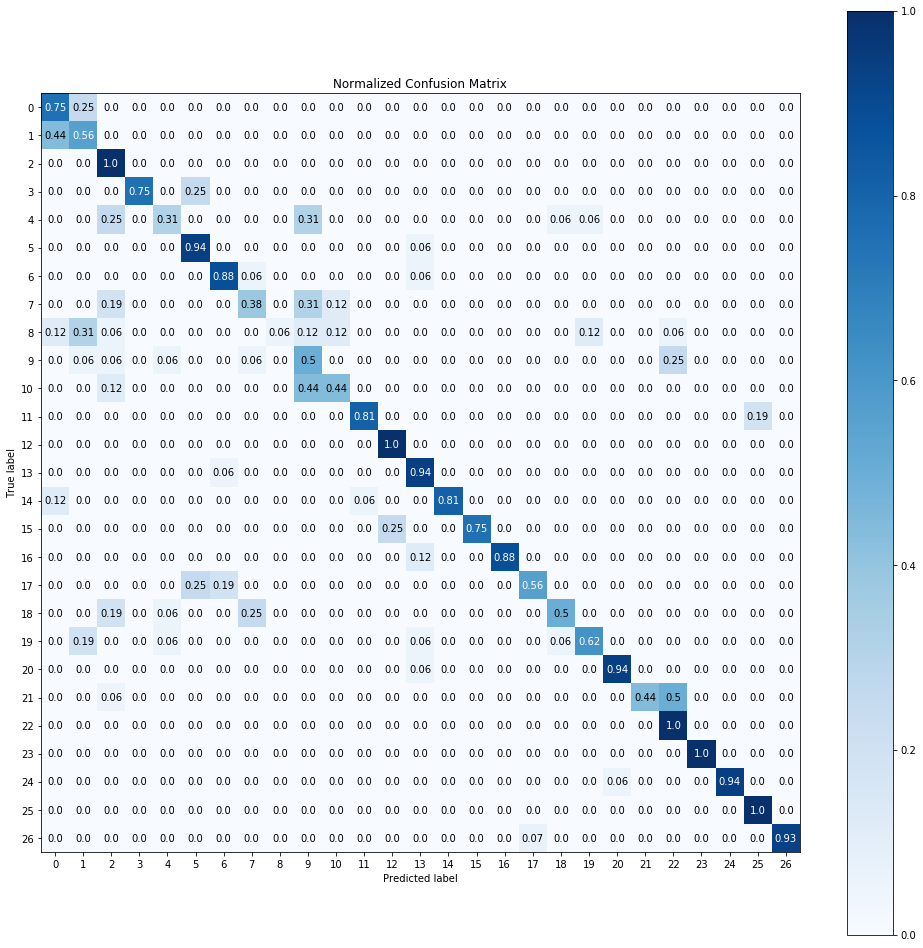

In [0]:
skplt.metrics.plot_confusion_matrix(tsLbl, y_pred, normalize=True, figsize=(17,17))

# Gradient Boosting - Xgboost

## Training Model

In [0]:
from xgboost import XGBClassifier
import time 
start =time.clock()


xgclf = XGBClassifier(n_estimators=200,
                      learning_rate=0.1,
                      gamma=0, 
                      subsample=0.75,
                      colsample_bytree=1,
                      max_depth=5,
                      min_weight=1, 
                      random_state=27,
                      booster='gbtree',
                      )

xgclf.fit(trDat,trLbl)
y_pred = xgclf.predict(tsDat)

end = time.clock()
print('Running time: %s Seconds'%(end-start))

Running time: 2.3268150000000105 Seconds


## Evaluate Model

In [0]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(tsLbl,y_pred))  
print(classification_report(tsLbl,y_pred))  
print(accuracy_score(tsLbl, y_pred)) 

[[13  0  2  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [10  5  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  1 14  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0 10  0  3  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  1  0  9  0  0  0  2  0  0  0  0  0  2  0  0  0  2  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0 15  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0 14  1  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0
   0  0  0]
 [ 1  0  1  0  0  0  0  3  0  5  3  0  0  0  0  0  0  0  3  0  0  0  0  0
   0  0  0]
 [ 1  6  0  0  0  0  0  0  5  2  0  0  0  0  0  0  0  0  0  2  0  0  0  0
   0  0  0]
 [ 0  3  1  0  0  0  0  0  6  5  1  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  3  0  0  0  0  0  3  1  9  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 10  0  0  6  0  0  

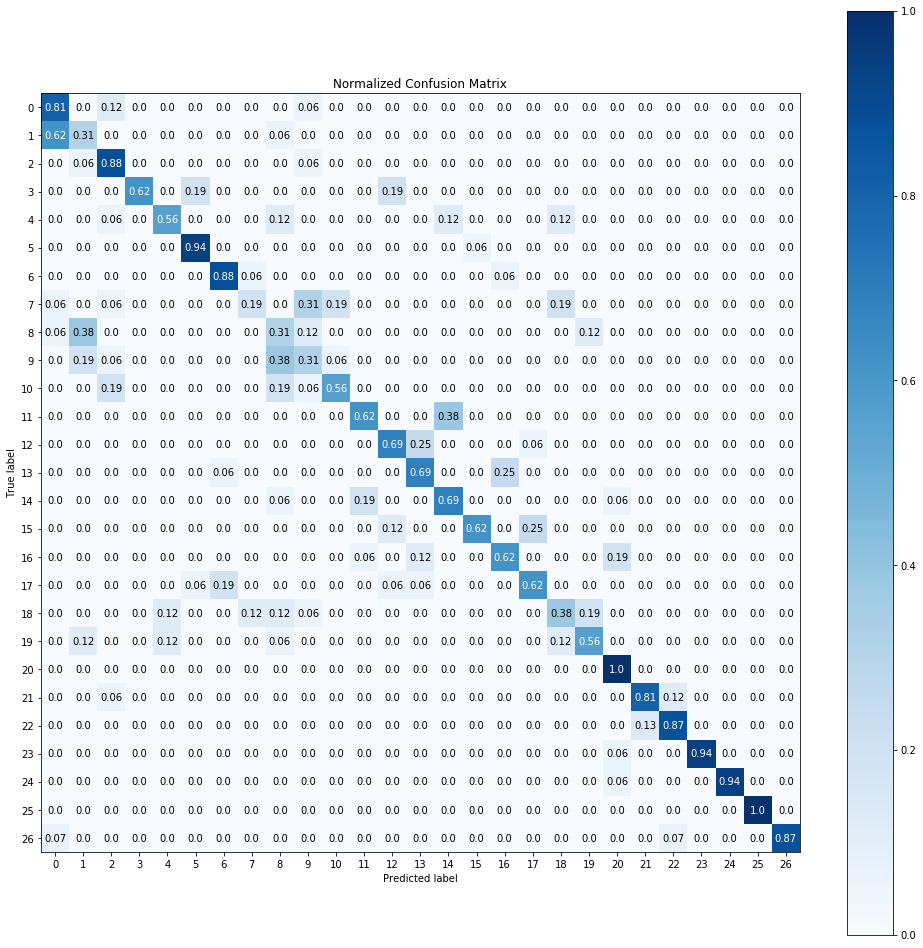

In [0]:
skplt.metrics.plot_confusion_matrix(tsLbl, y_pred, normalize=True, figsize=(17,17))

# Convolutional Neural Network

In [0]:
trDat.shape, tsDat.shape

((431, 36), (430, 36))

In [0]:
trDat_cnn = trDat.reshape((trDat.shape[0], trDat.shape[1],1))
tsDat_cnn = tsDat.reshape((tsDat.shape[0], tsDat.shape[1],1))

In [0]:
trDat_cnn.shape, tsDat_cnn.shape

((431, 36, 1), (430, 36, 1))

In [0]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers

In [0]:
def kerasConv():

    model = Sequential()
    model.add(Conv1D(48, 3, padding='same', 
                     kernel_regularizer=regularizers.l2(0.0001), 
                     input_shape=(36,1)))
    model.add(Conv1D(64, 3, padding='same',
                     kernel_regularizer=regularizers.l2(0.0001)))
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu',
                    kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dropout(0.5))
    model.add(Dense(27, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
    
    return model

Note: Available metrics in KerasClassifier are: loss,acc,lr

In [0]:
kerasConvModel = KerasClassifier(build_fn=kerasConv, epochs=200, 
                                 batch_size=32, verbose=0)

In [0]:
kerasConvModel.fit(trDat_cnn,trLbl)
y_pred = kerasConvModel.predict(tsDat_cnn)

In [0]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(tsLbl,y_pred))  
print(classification_report(tsLbl,y_pred))  
print(accuracy_score(tsLbl, y_pred)) 

[[10  3  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 8  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0 15  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0 13  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  3  0  5  0  0  0  0  3  0  0  0  1  0  0  0  0  2  2  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0 13  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  1  0
   0  0  0]
 [ 0  0  0  0  0  0 12  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  1  0  0  0  0 10  1  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 4  4  0  0  0  0  0  0  0  4  3  0  0  0  0  0  0  0  0  1  0  0  0  0
   0  0  0]
 [ 4  2  1  0  0  0  0  0  0  7  0  0  0  1  0  0  0  0  0  0  0  0  1  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0  1  7  7  0  0  0  0  0  0  0  1  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  8  0  0  0  0  0  

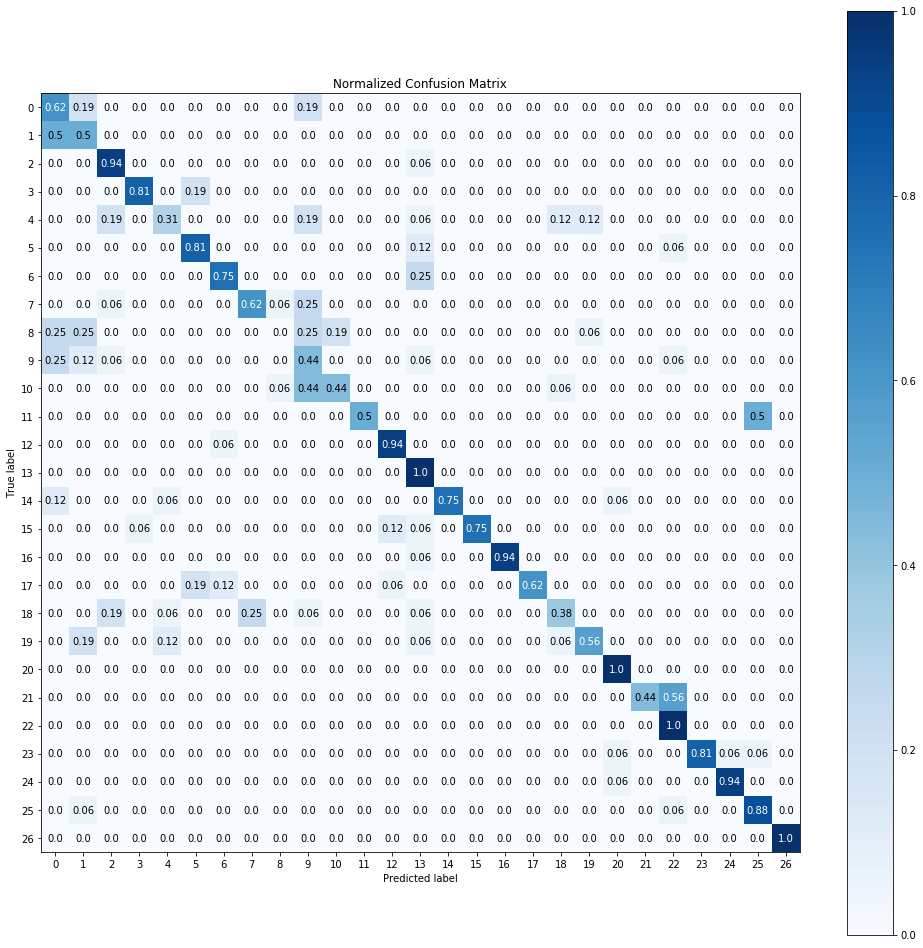

In [0]:
skplt.metrics.plot_confusion_matrix(tsLbl, y_pred, normalize=True, figsize=(17,17))

# Arbitrator using Voting Classifier

In [0]:
from sklearn.preprocessing import LabelEncoder

def fit_multiple_estimators(classifiers, X_list, y, sample_weights = None):

    le_ = LabelEncoder()
    le_.fit(y)
    transformed_y = le_.transform(y)
    estimators_ = []
    
    for clf, X in zip([clf for _, clf in classifiers], X_list):
        if sample_weights is None:
            clf.fit(X, y)
        else:
            clf.fit(X, y, sample_weights)
        estimators_.append(clf)


    return estimators_, le_


def predict_from_multiple_estimator(estimators, label_encoder, X_list, weights = None):

    # Predict 'soft' voting with probabilities

    pred1 = np.asarray([clf.predict_proba(X) for clf, X in zip(estimators, X_list)])
    pred2 = np.average(pred1, axis=0, weights=weights)
    pred = np.argmax(pred2, axis=1)

    return label_encoder.inverse_transform(pred)

In [0]:
rfvc = RandomForestClassifier(n_estimators=200,min_samples_split=3,max_depth=9,random_state=0)

params = {'learning_rate': 0.1, 'n_estimators': 500, 'seed':27, 
          'subsample': 0.6, 'colsample_bytree': 0.6, 'booster': 'gbtree',
          'max_depth': 5, 'min_child_weight': 1,
          'objective': 'multi:softmax'}

xgbvc = XGBClassifier(**params)

kerasvc = KerasClassifier(build_fn=kerasConv, epochs=200, 
                          batch_size=32, verbose=0)

In [0]:
estimators=[('rfvc', rfvc), ('xgbvc',xgbvc), ('kerasvc', kerasvc)]
X_train_list = [trDat, trDat, trDat_cnn]
X_valid_list = [tsDat, tsDat, tsDat_cnn]

In [0]:
fitted_estimators, label_encoder = fit_multiple_estimators(estimators, X_train_list, trLbl)

In [0]:
y_pred = predict_from_multiple_estimator(fitted_estimators, label_encoder, X_valid_list)

In [0]:
print(confusion_matrix(tsLbl, y_pred))
print(classification_report(tsLbl, y_pred))
print(accuracy_score(tsLbl, y_pred))

[[13  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [10  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0 15  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0 12  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  4  0  7  0  0  0  0  3  0  0  0  0  0  0  0  0  1  1  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  2  0  0  0  0  6  0  6  2  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 4  4  0  0  0  0  0  0  0  4  2  1  0  0  0  0  0  0  0  1  0  0  0  0
   0  0  0]
 [ 1  2  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  3  0
   0  0  0]
 [ 0  0  2  0  0  0  0  0  0  8  6  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 12  0  0  0  0  0  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


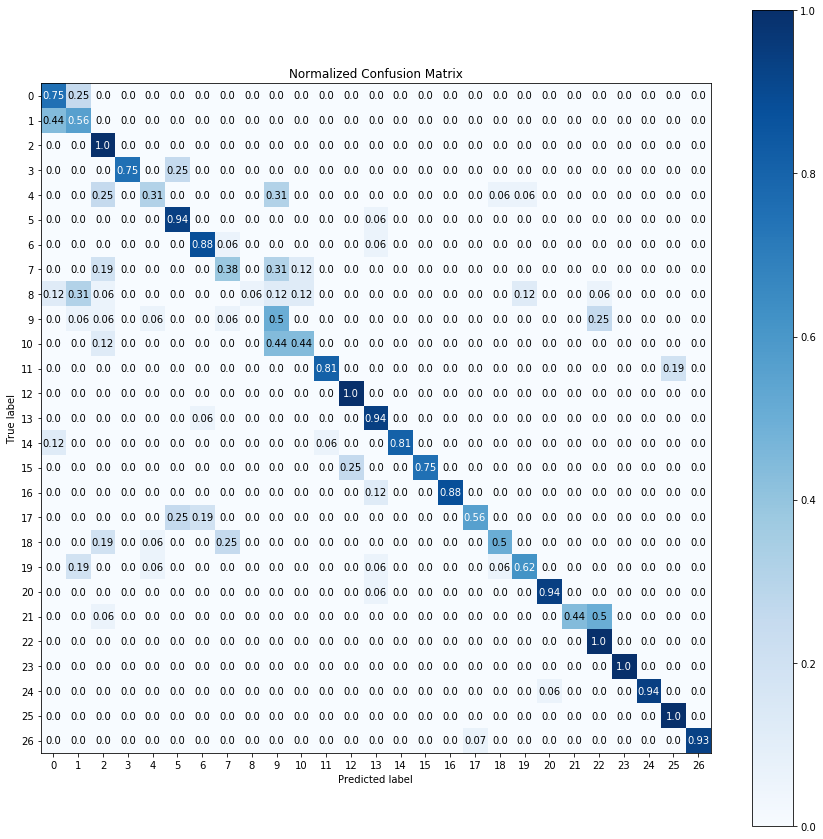

In [0]:
skplt.metrics.plot_confusion_matrix(tsLbl, y_pred, normalize=True, figsize=(15,15))

# Grid Search
- Can take a long time to run given Colab having lower CPU power
- These results are obtained locally with multi-core CPU

## Grid Search - RF

In [0]:
from sklearn.model_selection import GridSearchCV

param_grid = { 
    'n_estimators': [100, 200, 300],
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth' : [None, 11, 9, 7],
    'min_samples_split': [2,3,4],
    'min_samples_leaf': [1,2,3],
    'class_weight' : ['balanced', 'balanced_subsample', None],
    'criterion' :['gini', 'entropy']
}
rfc = RandomForestClassifier(random_state=0)
rfcv = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, n_jobs=-1)

In [0]:
rfcv.fit(trDat, trLbl)

/home/ubudgie/miniconda3/envs/tf2gpu/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=Fa...
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'class_weight': ['bal

In [0]:
print(rfcv.best_params_, rfcv.best_score_)

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 300} 0.8955916473317865


In [0]:
y_pred = rfcv.best_estimator_.predict(tsDat)

In [0]:
print(confusion_matrix(tsLbl,y_pred))  
print(classification_report(tsLbl,y_pred))  
print(accuracy_score(tsLbl, y_pred)) 

[[16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [11  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0 13  0  0  0  0  0  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0 15  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  2  0 11  0  0  0  0  0  0  0  0  0  1  0  0  0  1  1  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0 12  3  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0 15  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  8  0  6  1  0  0  0  0  0  0  0  1  0  0  0  0  0
   0  0  0]
 [ 3  5  0  0  0  0  0  0  4  3  0  0  0  0  0  0  0  0  0  1  0  0  0  0
   0  0  0]
 [ 3  4  0  0  0  0  0  0  0  5  4  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  2  0  0  0  0  0  1  4  9  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  

## Grid Search XGB

In [0]:
from sklearn.model_selection import GridSearchCV

cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5], 
             'subsample': [0.6, 0.75, 0.9], 'colsample_bytree': [0.6, 0.8, 1]}
                        
ind_params = {'learning_rate': 0.1, 'n_estimators': 500, 'seed':27, 
              'subsample': 0.75, 'colsample_bytree': 1, 'booster': 'gbtree',
             'objective': 'multi:softmax'}
xgbcv = GridSearchCV(XGBClassifier(**ind_params), 
                     cv_params, 
                     scoring = 'accuracy', cv = 5, n_jobs = -1) 

In [0]:
xgbcv.fit(trDat, trLbl)

/home/ubudgie/miniconda3/envs/tf2gpu/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=500, n_jobs=1,
                                     nthread=None, objective='multi:softmax',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.75, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1],
                         'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5],
                         'subs

In [0]:
# Mean cross-validated score of the best_estimator
print(xgbcv.best_params_, np.sqrt(np.abs(xgbcv.best_score_))), 
print(np.sqrt(np.abs(xgbcv.score(trDat, trLbl))))

{'colsample_bytree': 0.6, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.6} 0.9050002884208178
1.0


In [0]:
y_pred = xgbcv.best_estimator_.predict(tsDat)

In [0]:
print(confusion_matrix(tsLbl,y_pred))  
print(classification_report(tsLbl,y_pred))  
print(accuracy_score(tsLbl, y_pred)) 

[[14  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [11  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0 13  0  0  0  0  0  1  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0 13  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  7  0  0  0  2  0  0  0  0  0  1  0  0  0  4  2  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0 15  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0 15  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  1  0  0  0  0  5  0  7  2  0  0  0  0  0  0  0  1  0  0  0  0  0
   0  0  0]
 [ 2  4  0  0  0  0  0  0  4  3  1  0  0  0  0  0  0  0  0  2  0  0  0  0
   0  0  0]
 [ 1  2  1  0  0  0  0  0  3  6  2  0  0  0  0  0  0  0  0  1  0  0  0  0
   0  0  0]
 [ 0  0  2  0  1  0  0  0  1  3  9  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 10  0  0  6  0  0  